<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Goals" data-toc-modified-id="Goals-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Goals</a></span></li><li><span><a href="#Numpy-basics" data-toc-modified-id="Numpy-basics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Numpy basics</a></span><ul class="toc-item"><li><span><a href="#Python-solution" data-toc-modified-id="Python-solution-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Python solution</a></span></li><li><span><a href="#Cythonizing-the-function" data-toc-modified-id="Cythonizing-the-function-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Cythonizing the function</a></span></li><li><span><a href="#Numpy-array-of-couple-objects" data-toc-modified-id="Numpy-array-of-couple-objects-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Numpy array of couple objects</a></span></li><li><span><a href="#Numpy-&quot;vectorized&quot;-solution" data-toc-modified-id="Numpy-&quot;vectorized&quot;-solution-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Numpy "vectorized" solution</a></span><ul class="toc-item"><li><span><a href="#Vectorized-expressions-vs-length" data-toc-modified-id="Vectorized-expressions-vs-length-2.4.1"><span class="toc-item-num">2.4.1&nbsp;&nbsp;</span>Vectorized expressions vs length</a></span></li></ul></li></ul></li><li><span><a href="#Convolution" data-toc-modified-id="Convolution-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Convolution</a></span><ul class="toc-item"><li><span><a href="#Convolution-basics" data-toc-modified-id="Convolution-basics-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Convolution basics</a></span></li><li><span><a href="#Convolution-across-channels" data-toc-modified-id="Convolution-across-channels-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Convolution across channels</a></span></li><li><span><a href="#Gaussian-blur" data-toc-modified-id="Gaussian-blur-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Gaussian blur</a></span></li></ul></li></ul></div>

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
%load_ext cython
%timeit

import Cython
import numpy as np
import os
import subprocess
import matplotlib
#matplotlib.style.use('ggplot')
import pandas

# Goals

This notebook presents how to use numpy in cython effectively.

To use cython code inisde a cell use the ``%%cython`` marker to compile it.

# Numpy basics

Let us consider we have a python list of tuples. Each tuple contains the earnings of a "married couple". Component 0 contains female earnings and component 1 male earnings. We want a function that counts the number of couples where the female earns more than the male.

A numpy solution would be to store all wages in M,F arrays and then simply do `np.sum(F>M)`.
Let us try to do it iterating over an array.

In [2]:
import random
from collections import namedtuple
Couple = namedtuple('Couple', ['female', 'male'])#, verbose=False)

In [3]:
def create_couples(n_couples:int):
    couples = []

    for n in range(n_couples):
        couple = Couple(random.randint(70_000,200_000),random.randint(70_000,200_000))
        couples.append(couple)
    return couples

couples = create_couples(100_0000)

## Python solution

In [4]:
def py_count_women_earning_more(couples):
    count = 0
    for c in couples:
        count += c.female > c.male
    return count

In [5]:
%%timeit -o
py_count_women_earning_more(couples)

124 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 124 ms ± 2.81 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [6]:
timeit_py_count_women_earning_more = _

## Cythonizing the function 

In [7]:
%%cython -a
cpdef int cy_count_women_earning_more(couples):
    cdef count = 0
    for c in couples:
        count += c.female > c.male
    return count

In [8]:
%%timeit -o
cy_count_women_earning_more(couples)

95.5 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


<TimeitResult : 95.5 ms ± 2.58 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)>

In [9]:
timeit_cy_count_women_earning_more = _

In [10]:
speedup = timeit_py_count_women_earning_more.average/timeit_cy_count_women_earning_more.average

In [11]:
speedup

1.2945859355794958

## Numpy array of couple objects

In [12]:
import numpy as np
np_couples = np.array(couples)

In [13]:
len(np_couples)

1000000

Now we want to do the same computation but using a numpy array.

Notice there are two lines of code
```
@cython.boundscheck(False)
@cython.wraparound(False)
```
that prevent, at runtime, unnecessary checks.  This is needed in order to perform `r = couples[n,0] > couples[n,1]` fast because we don't want cython to check for every `n` if  `couples[n,0]` and `couples[n,0]` is defined. We already know, by construction of the function, that `n<N` and that the array we are iterating over has `N` elements.

Usually you might want to make first a version that works with boundscheck and wraparaound enabled. After some testing is done, there is no need to use it in the presented case.

In [14]:
%%cython -a
cimport numpy as cnp
cimport cython
             
@cython.boundscheck(False)
@cython.wraparound(False)
cpdef int np_cy_count_women_earning_more(cnp.ndarray[long, ndim=2] couples):
    cdef long count = 0
    cdef long N = len(couples)
    cdef bint r

    for n in range(N):
        r = couples[n,0] > couples[n,1]
        count += r
    return count

In [15]:
%%timeit -o
np_cy_count_women_earning_more(np_couples)

908 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 908 µs ± 18.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [16]:
timeit_np_cy_count_women_earning_more = _

In [17]:
speedup = timeit_cy_count_women_earning_more.average
speedup /= timeit_np_cy_count_women_earning_more.average
print(f"cython with np is {speedup}X faster than cython wihout np")

speedup = timeit_py_count_women_earning_more.average
speedup /= timeit_np_cy_count_women_earning_more.average
print(f"cython with np is {speedup}X faster than python")

cython with np is 105.1976157508361X faster than cython wihout np
cython with np is 136.18735380752847X faster than python


## Numpy "vectorized" solution

The standard way to do it in python is already pretty fast, but our cython implementation is still twice faster.

In [18]:
%%timeit -o
np.sum(np_couples[:,0]>np_couples[:,1])

1.61 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


<TimeitResult : 1.61 ms ± 15.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)>

In [19]:
np_count_women_earning_more = _

In [20]:
speedup = np_count_women_earning_more.average
speedup /= timeit_np_cy_count_women_earning_more.average
print(f"cython with np is {speedup}X faster than `vectorized` numpy in pytho")

cython with np is 1.7749849815387386X faster than `vectorized` numpy in pytho


### Vectorized expressions vs length

Usually the smaller is the computation the higher is the benefit of using cython vs vectorized implementations because the overhead of python takes a bigger percentage of the overall function call.

Therefore, in cases where we might have a for loop that iterates over a big number and inside we have a "vectorized" numpy expression it is worth rewritting the code in cython.

In cases where we have a single vectorized numpy expression that we don't call many times it might not matter that much.

In [21]:
np_couples = np.array(couples[0:500])
np_couples.shape

(500, 2)

In [22]:
%%timeit -o
np.sum(np_couples[:,0]>np_couples[:,1])

5.27 µs ± 97.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


<TimeitResult : 5.27 µs ± 97.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)>

In [23]:
np_count_women_earning_more = _

In [24]:
%%timeit -o
np_cy_count_women_earning_more(np_couples)

1.04 µs ± 12.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


<TimeitResult : 1.04 µs ± 12.4 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)>

In [25]:
timeit_np_cy_count_women_earning_more = _

In [26]:
speedup = np_count_women_earning_more.average
speedup /= timeit_np_cy_count_women_earning_more.average
print(f"cython with np is {speedup}X faster than `vectorized` numpy in pytho")

cython with np is 5.071349997327737X faster than `vectorized` numpy in pytho


# Convolution


The goal now is to code a function that computes a convolution of 2D image with a given kernel.

Then we will generalize the function to compute the convolution across channels.

## Convolution basics


First let us assume we are using squared kernel matrices to simplify the ideas. It is straightforward to write a general case once the understand this.

Let us consider the following matrix representing an image of dimension
(4,7)

```
    x x x x x x x
    x x x x x x x
    x x x x x x x
    x x x x x x x
```

Let us consider a kernel of size 3x3
```
    k k k
    k k k
    k k k
```

We can make a diagram of the positions where we can place the kernel and have a defined convolution

The first position is centered at (1,1)

```
    k k k x x x x
    k k k x x x x
    k k k x x x x
    x x x x x x x
```
The second position is centered at (1,2)

```
    x k k k x x x
    x k k k x x x
    x k k k x x x
    x x x x x x x
```
and so on..


The following diagram shows with `V`  the valid positions at which we can center `K` and have a well defined `K*image_path(x,y)`
```
    x x x x x x x
    x V V V V V x
    x V V V V V x
    x x x x x x x
```


The following diagram shows with `V`  the valid positions at which we can center `K` and have a well defined `K*image_path(x,y)`.

Notice that if we want to place a kernel at position `(0,0)` then we face the following case:
```
  k k k
  k @ k x x x x x
  k k k V V V V x
    x V V V V V x
    x x x x x x x
```

We we need an extra row and extra column.


##### About kernels with even shapes

What  would happen if we had a 4x4 Kernel matrix? 

First notice that if the kernel has an even number of rows and columns then there is no "center"

```
Here we have one center

k k k
k @ k
k k k

Notice here we have 4 centers:

k k k k 
k @ @ k 
k @ @ k
k k k k

Here we have one

k k k k k 
k k k k k 
k k @ k k 
k k k k k 
k k k k k 

Here we have 4

k k k k k k
k k k k k k
k k @ @ k k
k k @ @ k k
k k k k k k
k k k k k k
```

When there are several possible centers to choose we can simply make an arbitrary decision (like the top left center), and be consistent across our code.

What is theferore a valid "center position"?
Most implementations assume the kernel has odd dimensions to precisely avoid this problem.

##### Padding pattern

Now let us assume we copy our image into a bigger image containing zeros at the border (this is usally called, a zero-padded image).

How many zeros should we add depending on the filter size? Do you notice a pattern?

```
Filter size     Number of appended rows and cols
3 x 3                      1
4 x 4                      2
5 x 5                      2
6 x 6                      3
```

The number of zeros can be computed as follows

```
Filter size     Number of appended rows and cols
3 x 3                      int(3/2)
4 x 4                      int(4/2)
5 x 5                      int(5/2)
6 x 6                      int(6/2)
```

In [27]:
print(int(3/2))
print(int(4/2))
print(int(5/2))
print(int(6/2))

1
2
2
3


##### Examples of zero padded images

In the case of the 4x4 filter we add 2 (int(4/2)) rows and cols to the original image in a new image we might call im_padded. Then we apply the convolution at all positions of the original image.



Diagram appending zeros. After appending zeros we have all positions
in our original array valid as centers to the kernel.

```
                ->  0 0 0 0 0 0 0 0 0 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
 x x x x x x x  ->  0 0 x x x x x x x 0 0 
 x V V V V V x  ->  0 0 x V V V V V x 0 0 
 x V V V V V x  ->  0 0 x V V V V V x 0 0 
 x x x x x x x  ->  0 0 x x x x x x x 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
```                                   

The right bottom position of the kernel is found here:

```
                ->  0 0 0 0 0 0 0 0 0 0 0 
                ->  0 0 0 0 0 0 0 0 0 0 0 
 x x x x x x x  ->  0 0 x x x x x x x 0 0 
 x V V V V V x  ->  0 0 x V V V V V x 0 0 
 x V V V V V x  ->  0 0 x V V V V k k k k 
 x x x x x x x  ->  0 0 x x x x x k @ k k 
                ->  0 0 0 0 0 0 0 k k k k 
                ->  0 0 0 0 0 0 0 k k k k 

```      


##### Valid convolution (without padding)

If we convolve $n \times n$ matrix by an $f \times f $ filter we get a
$ (n-f+1) \times  (n-f+1)$ matrix.

- A 6x6 image convolved by 3x3 filter returns a 4x4 output.

##### Same convolution (with padding)


If we pad an image by $p=\frac{f-1}{2}$ zeros on all rows and columns then:

- A 6x6 image convolved by 3x3 filter returns a 6x6 output.



In [28]:
%matplotlib inline

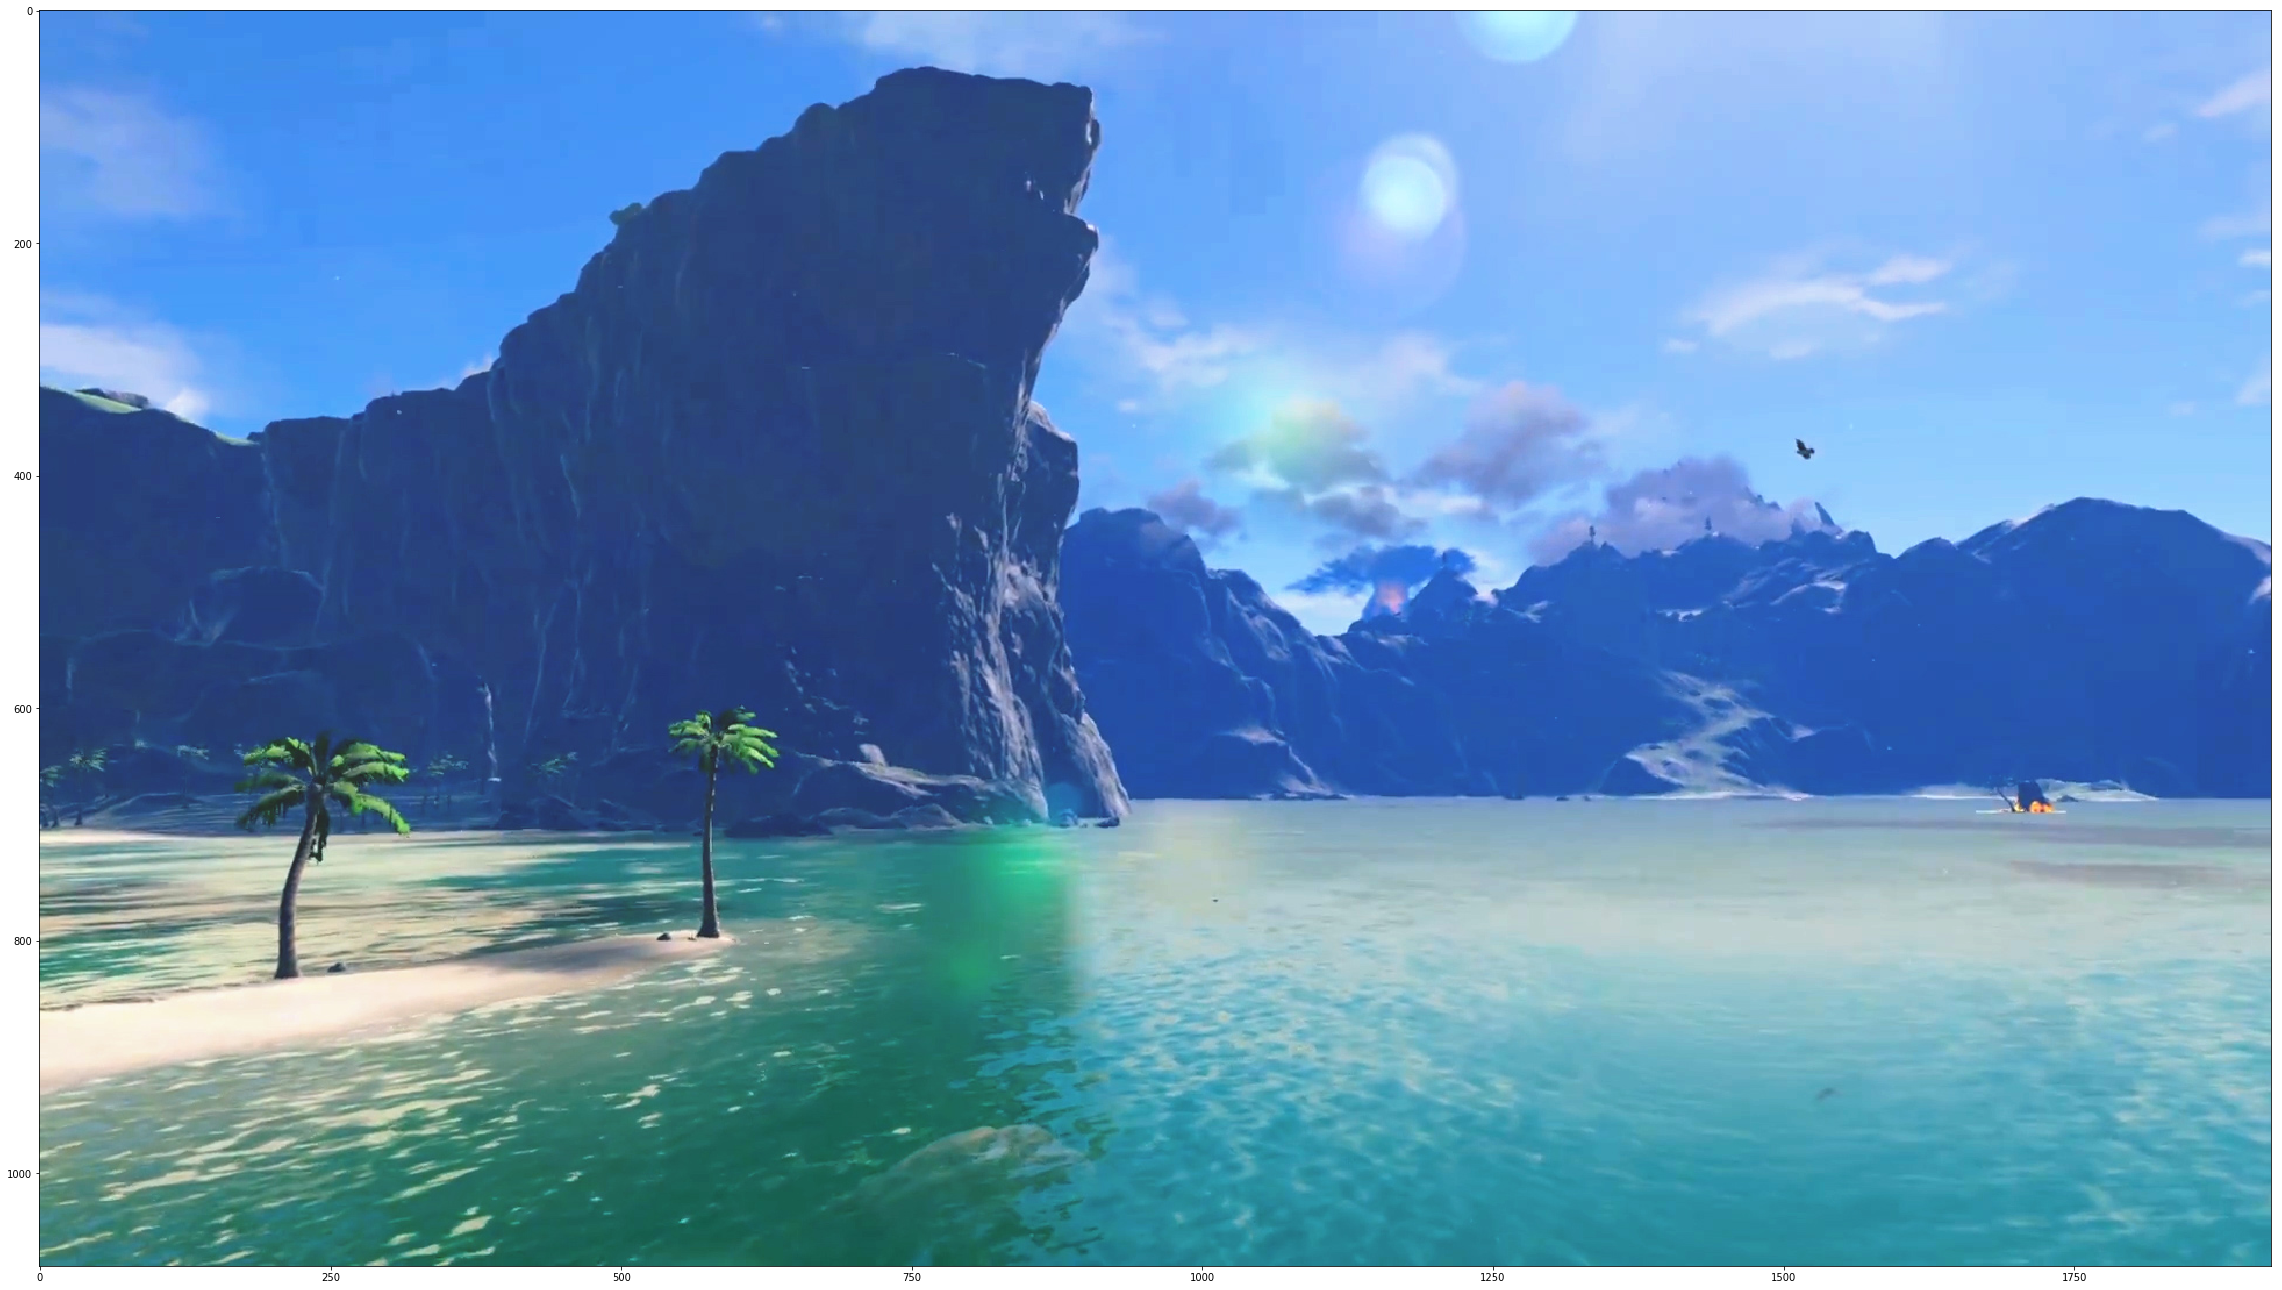

In [29]:
import io
import skimage
from matplotlib import pyplot as plt # useful for plotting images on iPython or Jupyter Notebooks

im = skimage.io.imread('./images/beach.jpg')
plt.figure(figsize = (40,40))
im_r = skimage.img_as_float(im[:,:,0])
plt.imshow(im)

In [30]:
def convolve_by_squaredK(image, K):
    assert image.ndim==2, "image has {} it should be 2".format(image.ndim)
    assert K.ndim==2, "K has {} it should be 2".format(image.ndim)
    assert K.shape[0]==K.shape[1],"K.shape={} but should be a squared matrix".format(K.shape)
    
    result = np.zeros(image.shape)
    n_row, n_col = image.shape
    
    # append zeros to result now
    p = int(K.shape[0]/2)
    f = K.shape[0]
    image_padded = np.zeros((n_row+2*p, n_col+2*p))
    image_padded[p:n_row+p, p:n_col+p] = image

    # iterate over positions 
    for r in range(n_row-1):
        for c in range(n_col-1):
            result[r,c] = np.sum(image_padded[r:r+f,c:c+f]*K)
            
    return result

In [34]:
#%%timeit -o
K = np.ones((31,31))
image_convolved = convolve_by_squaredK(im[:,:,1], K)

In [35]:
timeit_image_convolved = _

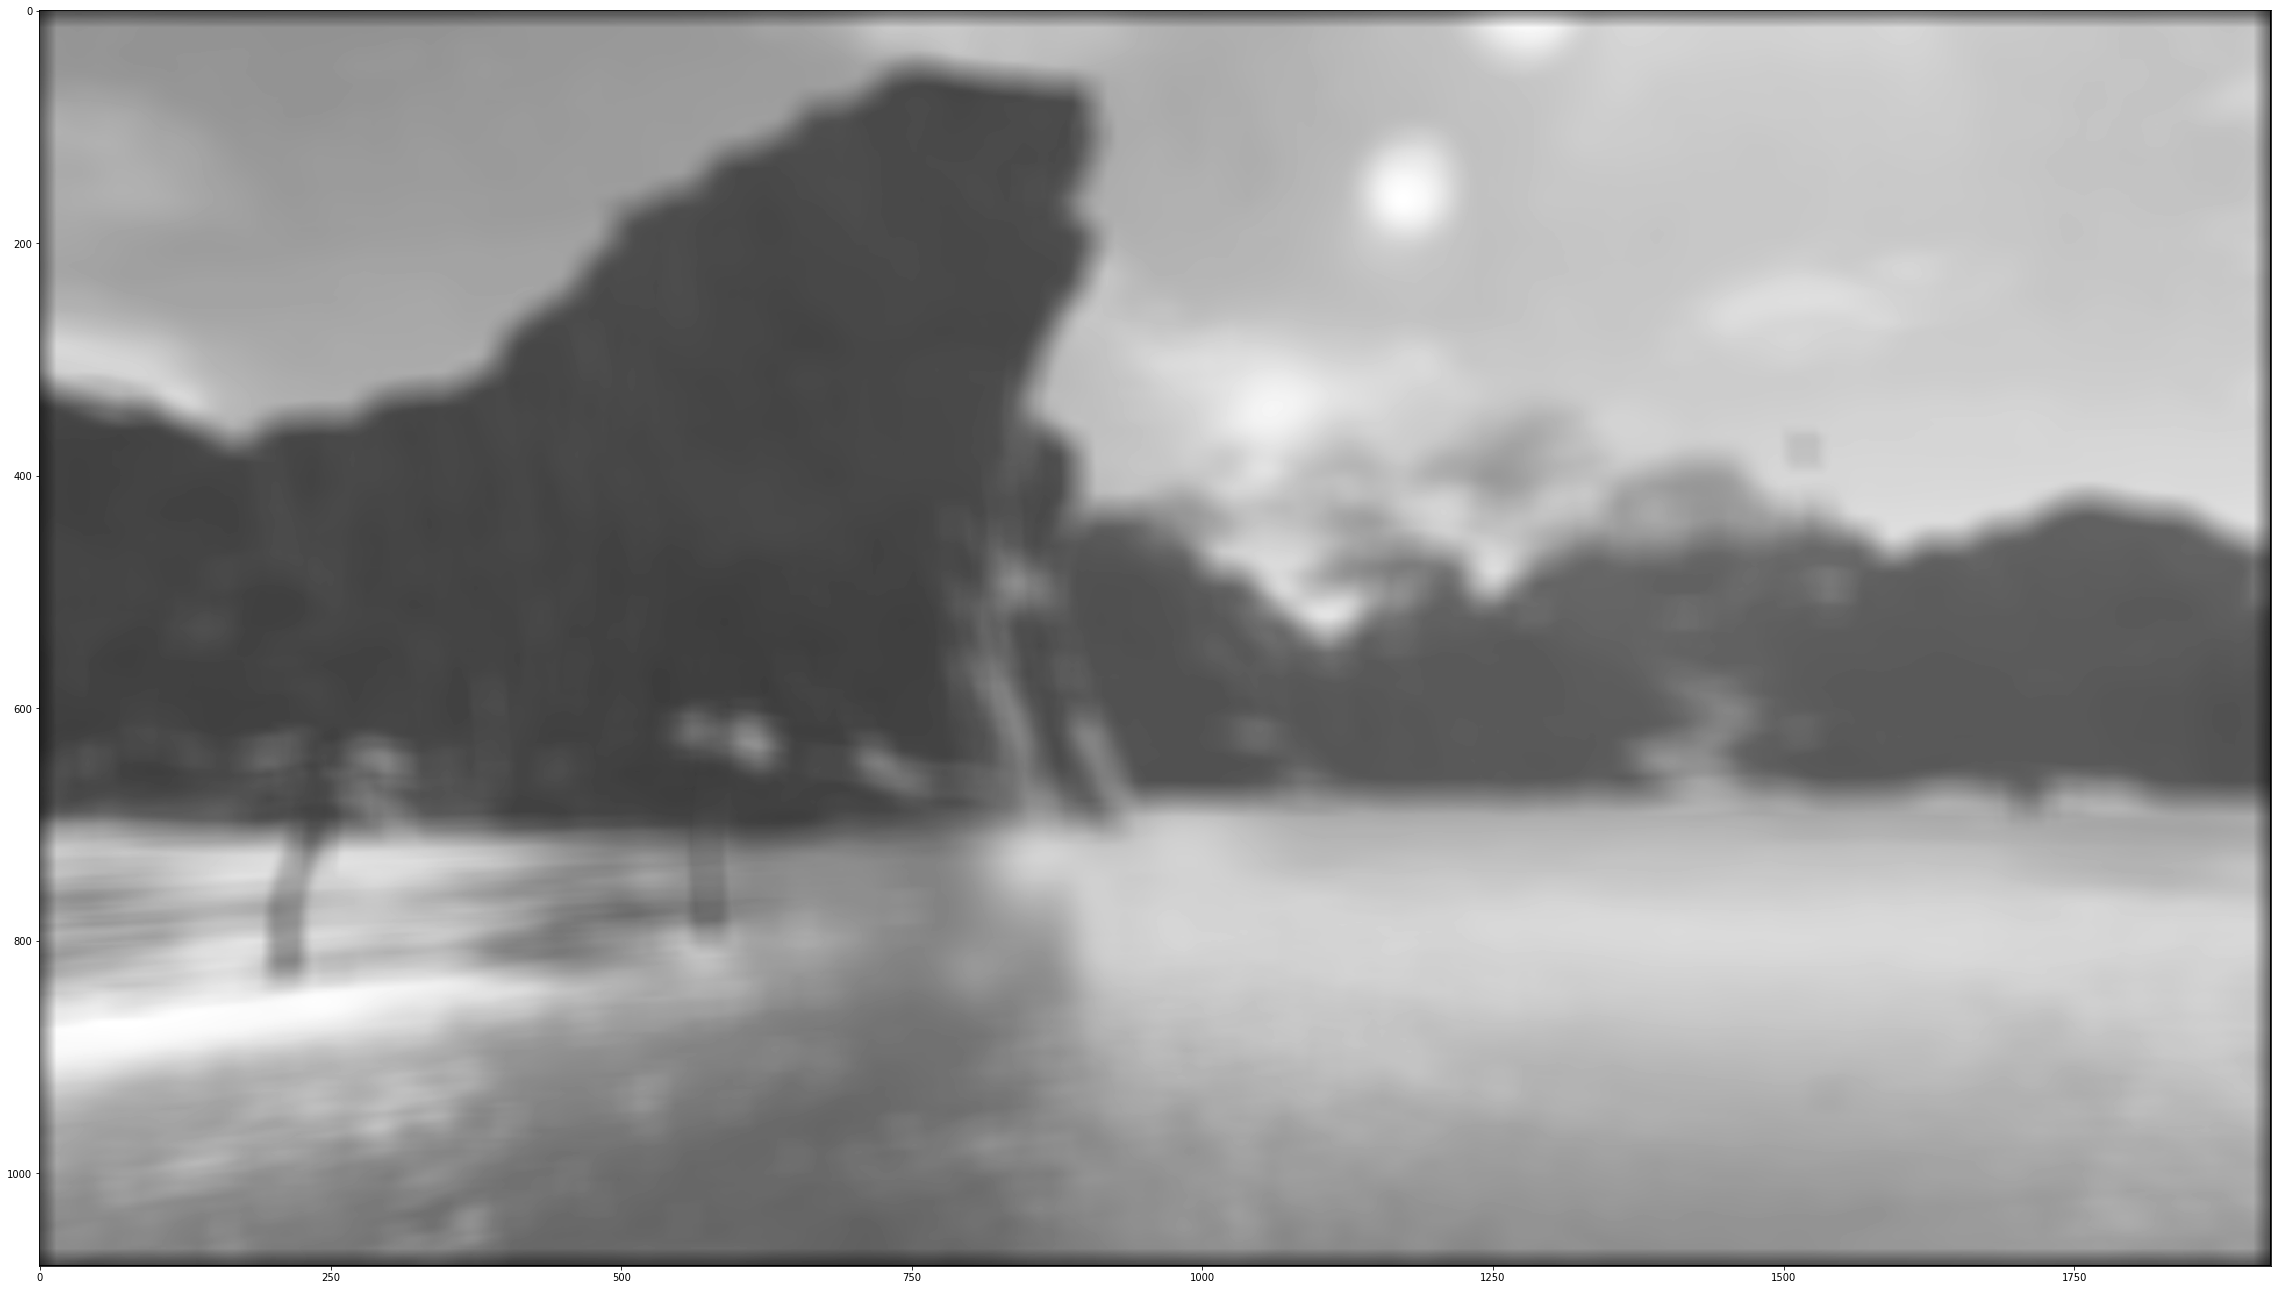

In [36]:
plt.figure(figsize = (40,40))
plt.imshow(image_convolved, cmap="gray")

One of the problems of the previous implementation is `image_padded[r:r+f,c:c+f]`  which we want to get rid of in cython 

In [37]:
%%cython

cimport numpy as np
import numpy as np

# We now need to fix a datatype for our arrays. I've used the variable
# DTYPE for this, which is assigned to the usual NumPy runtime
# type info object.
from cython.parallel import prange
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.cmultiplication(True)
def cy_convolve_by_squaredK(double[:, :] image, double[:,:] K):
    assert image.ndim==2, "image has {} it should be 2".format(image.ndim)
    assert K.ndim==2, "K has {} it should be 2".format(image.ndim)
    assert K.shape[0]==K.shape[1],"K.shape={} but should be a squared matrix".format(K.shape)
    
    cdef int n_row = image.shape[0]
    cdef int n_col = image.shape[1]

    # append zeros to result now
    cdef int p = int(K.shape[0]/2)
    cdef int f = K.shape[0]
    
    cdef double[:,:] result = np.zeros([n_row, n_col], dtype=np.float64)    
    cdef double[:,:] image_padded = np.zeros([n_row+2*p, n_col+2*p], dtype=np.float64)

    # write the image inside the padded image
    image_padded[p:n_row+p, p:n_col+p] = image
    cdef int c,r,i,j
    cdef double slice_by_K 
    
    # iterate over positions 
    for r in range(n_row-1):
        for c in range(n_col-1):
            slice_by_K = 0.0
            for j in range(f):
                for i in range(f):
                    slice_by_K +=image_padded[r+i,c+j]*K[i,j] 
            result[r,c] = slice_by_K

    return np.asarray(result)



In [46]:
%%timeit -o
K = np.ones((31,31))
cy_image_convolved = cy_convolve_by_squaredK(np.array(im[:,:,1],dtype="float64"), K)

1.9 s ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


<TimeitResult : 1.9 s ± 26.7 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)>

In [47]:
timeit_cy_image_convolved = _

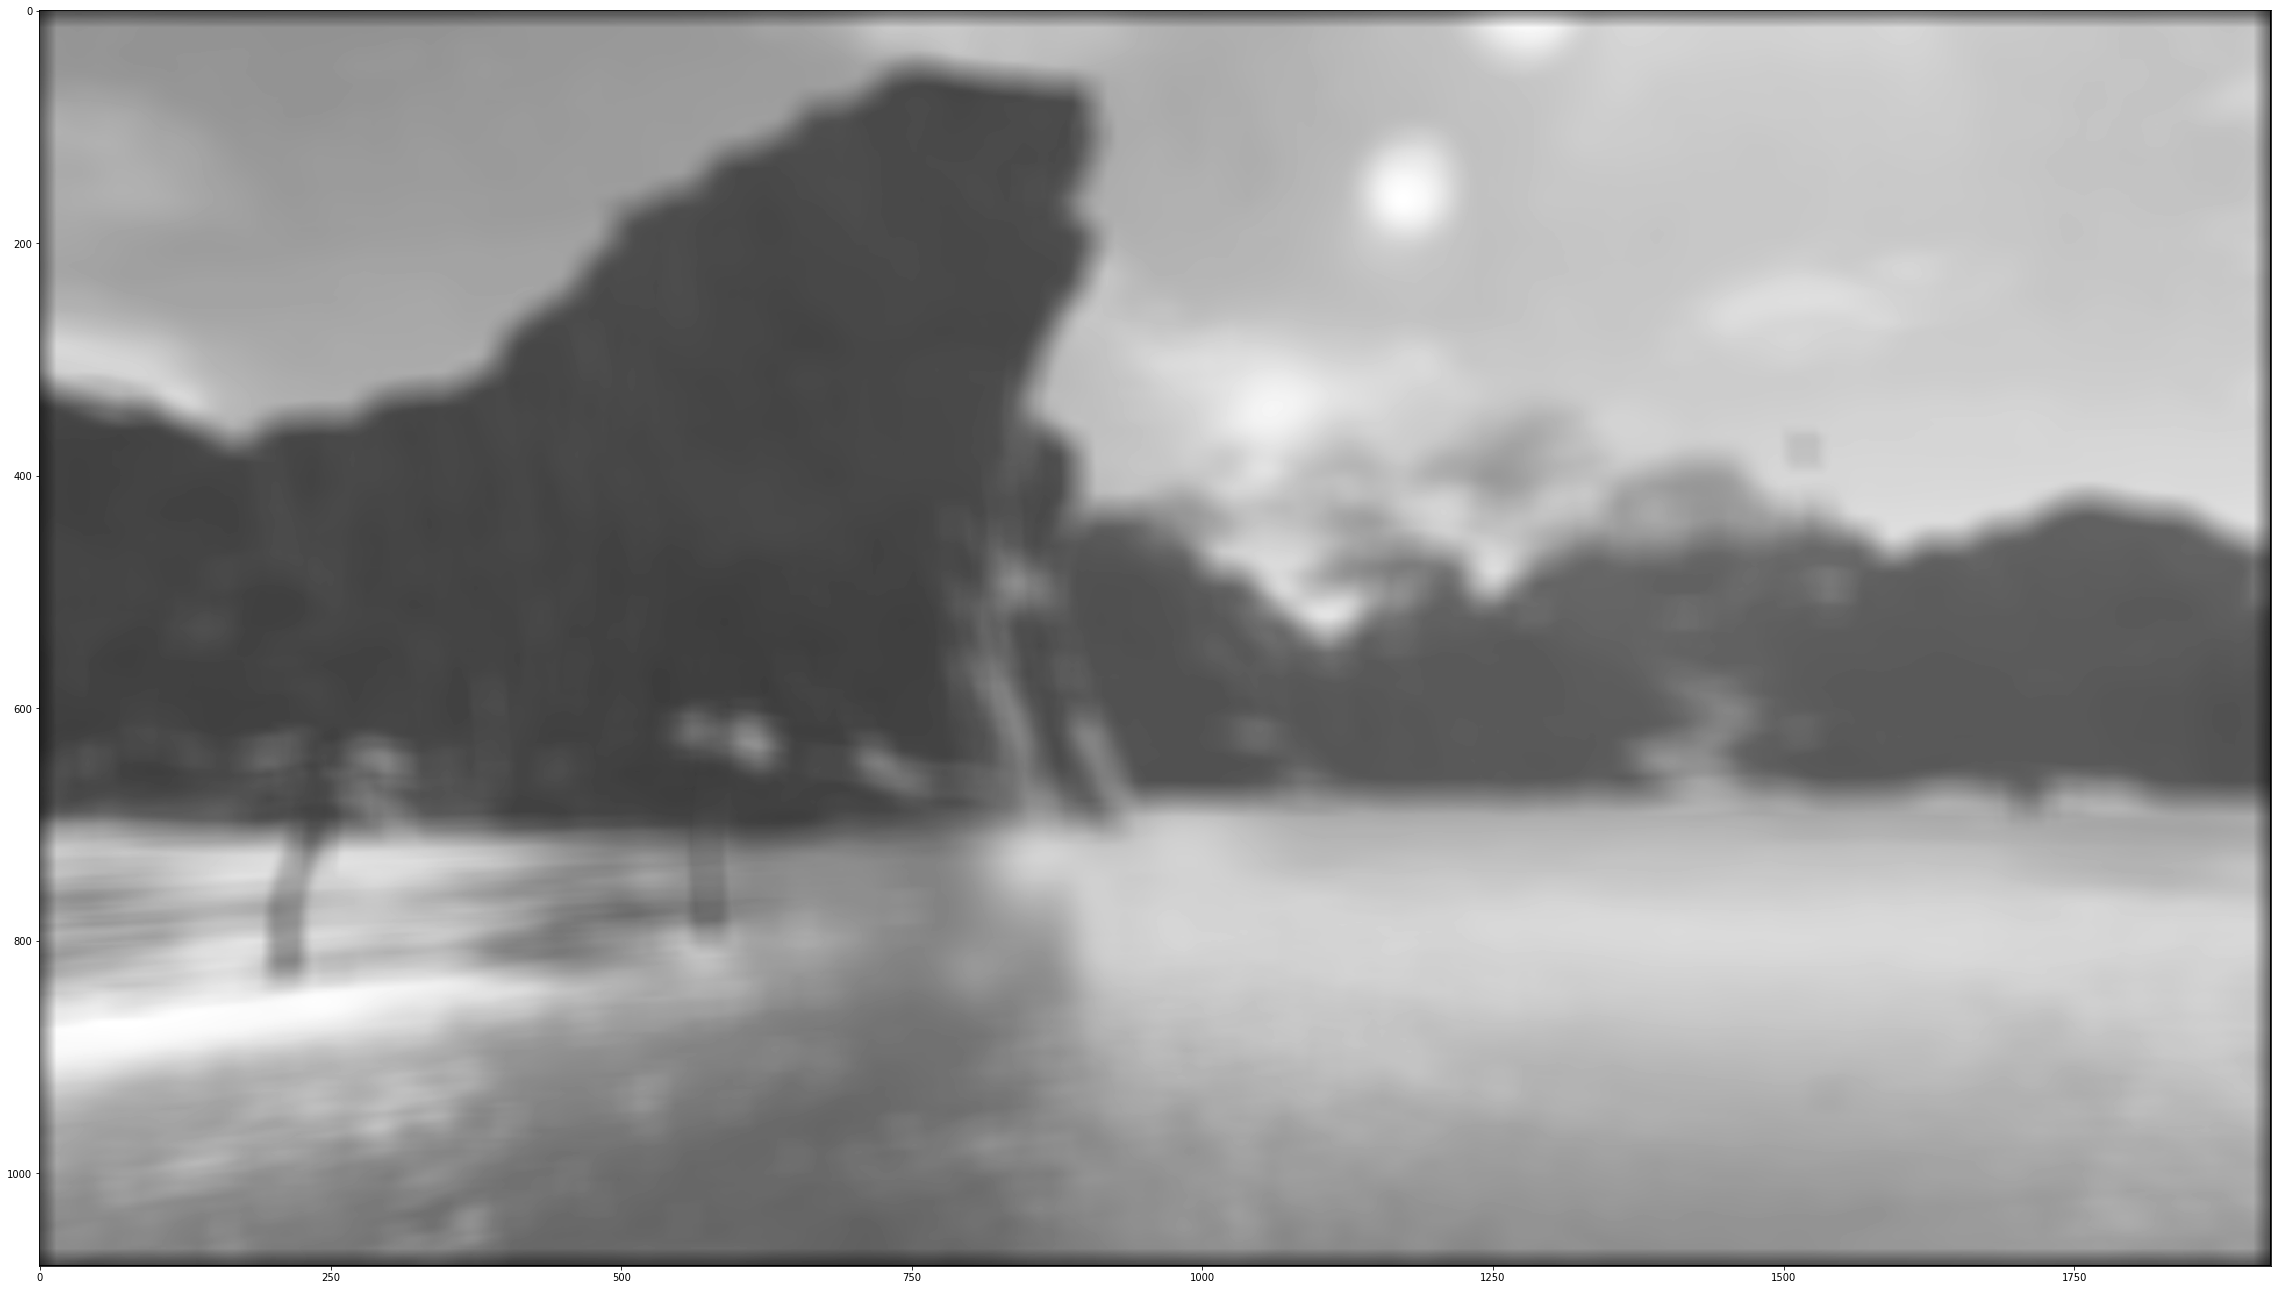

In [48]:
plt.figure(figsize = (40,40))
plt.imshow(cy_image_convolved, cmap="gray")

In [49]:
speedup = timeit_image_convolved.average
speedup /= timeit_cy_image_convolved.average
print(f"cython with np is {speedup}X faster than `vectorized` numpy in python")

cython with np is 7.696994979140934X faster than `vectorized` numpy in python


## Convolution across channels

In [50]:
%%cython

cimport numpy as np
import numpy as np

# We now need to fix a datatype for our arrays. I've used the variable
# DTYPE for this, which is assigned to the usual NumPy runtime
# type info object.
from cython.parallel import prange
cimport cython

@cython.boundscheck(False)
@cython.wraparound(False)
#@cython.cmultiplication(True)
def cy_convolve(double[:, :, :] image, double[:,:] K):
    
    assert image.ndim==3, "image has {} it should be 3".format(image.ndim)
    assert K.ndim==2, "K has {} it should be 2".format(image.ndim)
    
    cdef int n_row = image.shape[0]
    cdef int n_col = image.shape[1]
    cdef int n_channels = image.shape[2]
    
    # append zeros to result now
    cdef int p = int(K.shape[0]/2)
    cdef int f = K.shape[0]
    
    cdef double[:,:,:] result = np.zeros([n_row, n_col, n_channels], dtype=np.float64)    
    cdef double[:,:,:] image_padded = np.zeros([n_row+2*p, n_col+2*p, n_channels], dtype=np.float64)
    cdef double total
    cdef double kernel_val

    # write the image inside the padded image
    image_padded[p:n_row+p, p:n_col+p, :] = image
    cdef int c,r,i,j
    cdef double slice_by_K 
    
    K = K/np.sum(K)
    
    # iterate over positions 
    for r in range(n_row-1):
        for c in range(n_col-1):
            for cha in range(n_channels):
                slice_by_K = 0.0
                ###total = 0.0
                for j in range(f):
                    for i in range(f):
                        kernel_val = K[i,j] 
                        slice_by_K +=image_padded[r+i,c+j,cha]*kernel_val
                        ###total += kernel_val
                        
                result[r,c,cha] = slice_by_K
                ###result[r,c,cha] = cython.cdiv(slice_by_K,total)

    return np.asarray(result)

In [51]:
K = np.ones((31,31))
cy_image_convolved = cy_convolve(np.array(im, dtype="float64"), K/np.sum(K))

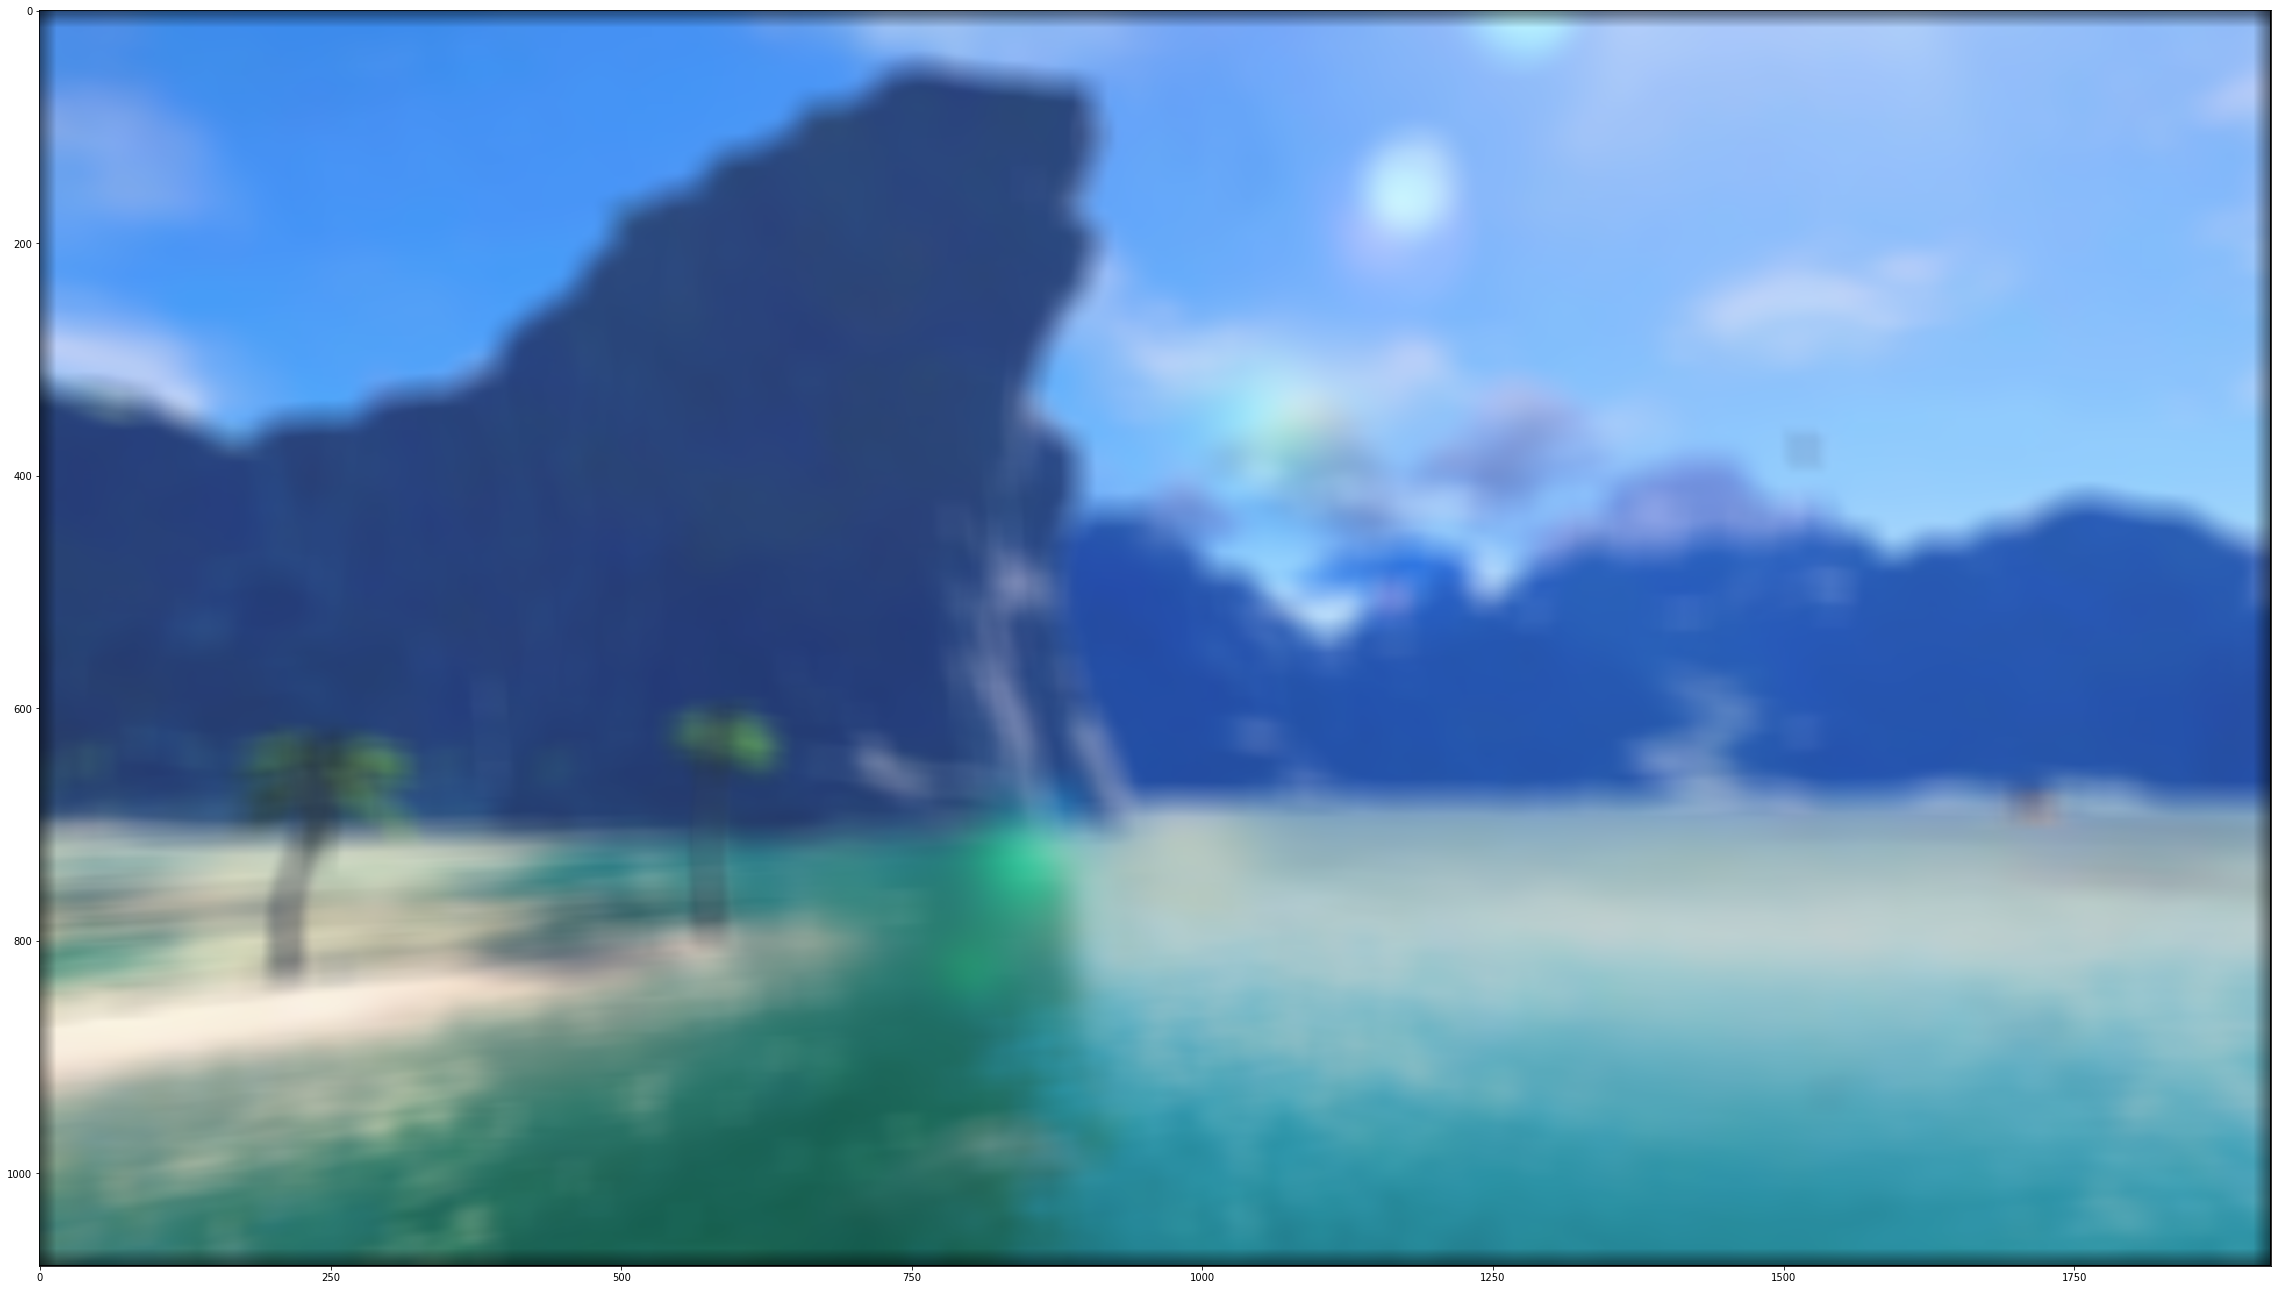

In [52]:
plt.figure(figsize = (40,40))
plt.imshow(np.array(cy_image_convolved,dtype="uint8"))

## Gaussian blur 

Now Let us do a more reallistic blur using a Guassian function as our kernel

In [53]:
def gaussian_kernel_2d(sigma):
    kernel_radius = np.ceil(sigma) * 3
    kernel_size = kernel_radius * 2 + 1
    ax = np.arange(-kernel_radius, kernel_radius + 1., dtype=np.float64)
    xx, yy = np.meshgrid(ax, ax)
    kernel = np.exp(-(xx**2 + yy**2) / (2. * sigma**2))
    return kernel / np.sum(kernel)

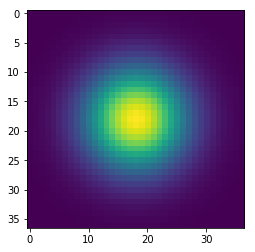

In [54]:
K_g = gaussian_kernel_2d(6)
plt.imshow(K_g)

In [55]:
cy_image_convolved = cy_convolve(np.array(im, dtype="float64"), K_g)

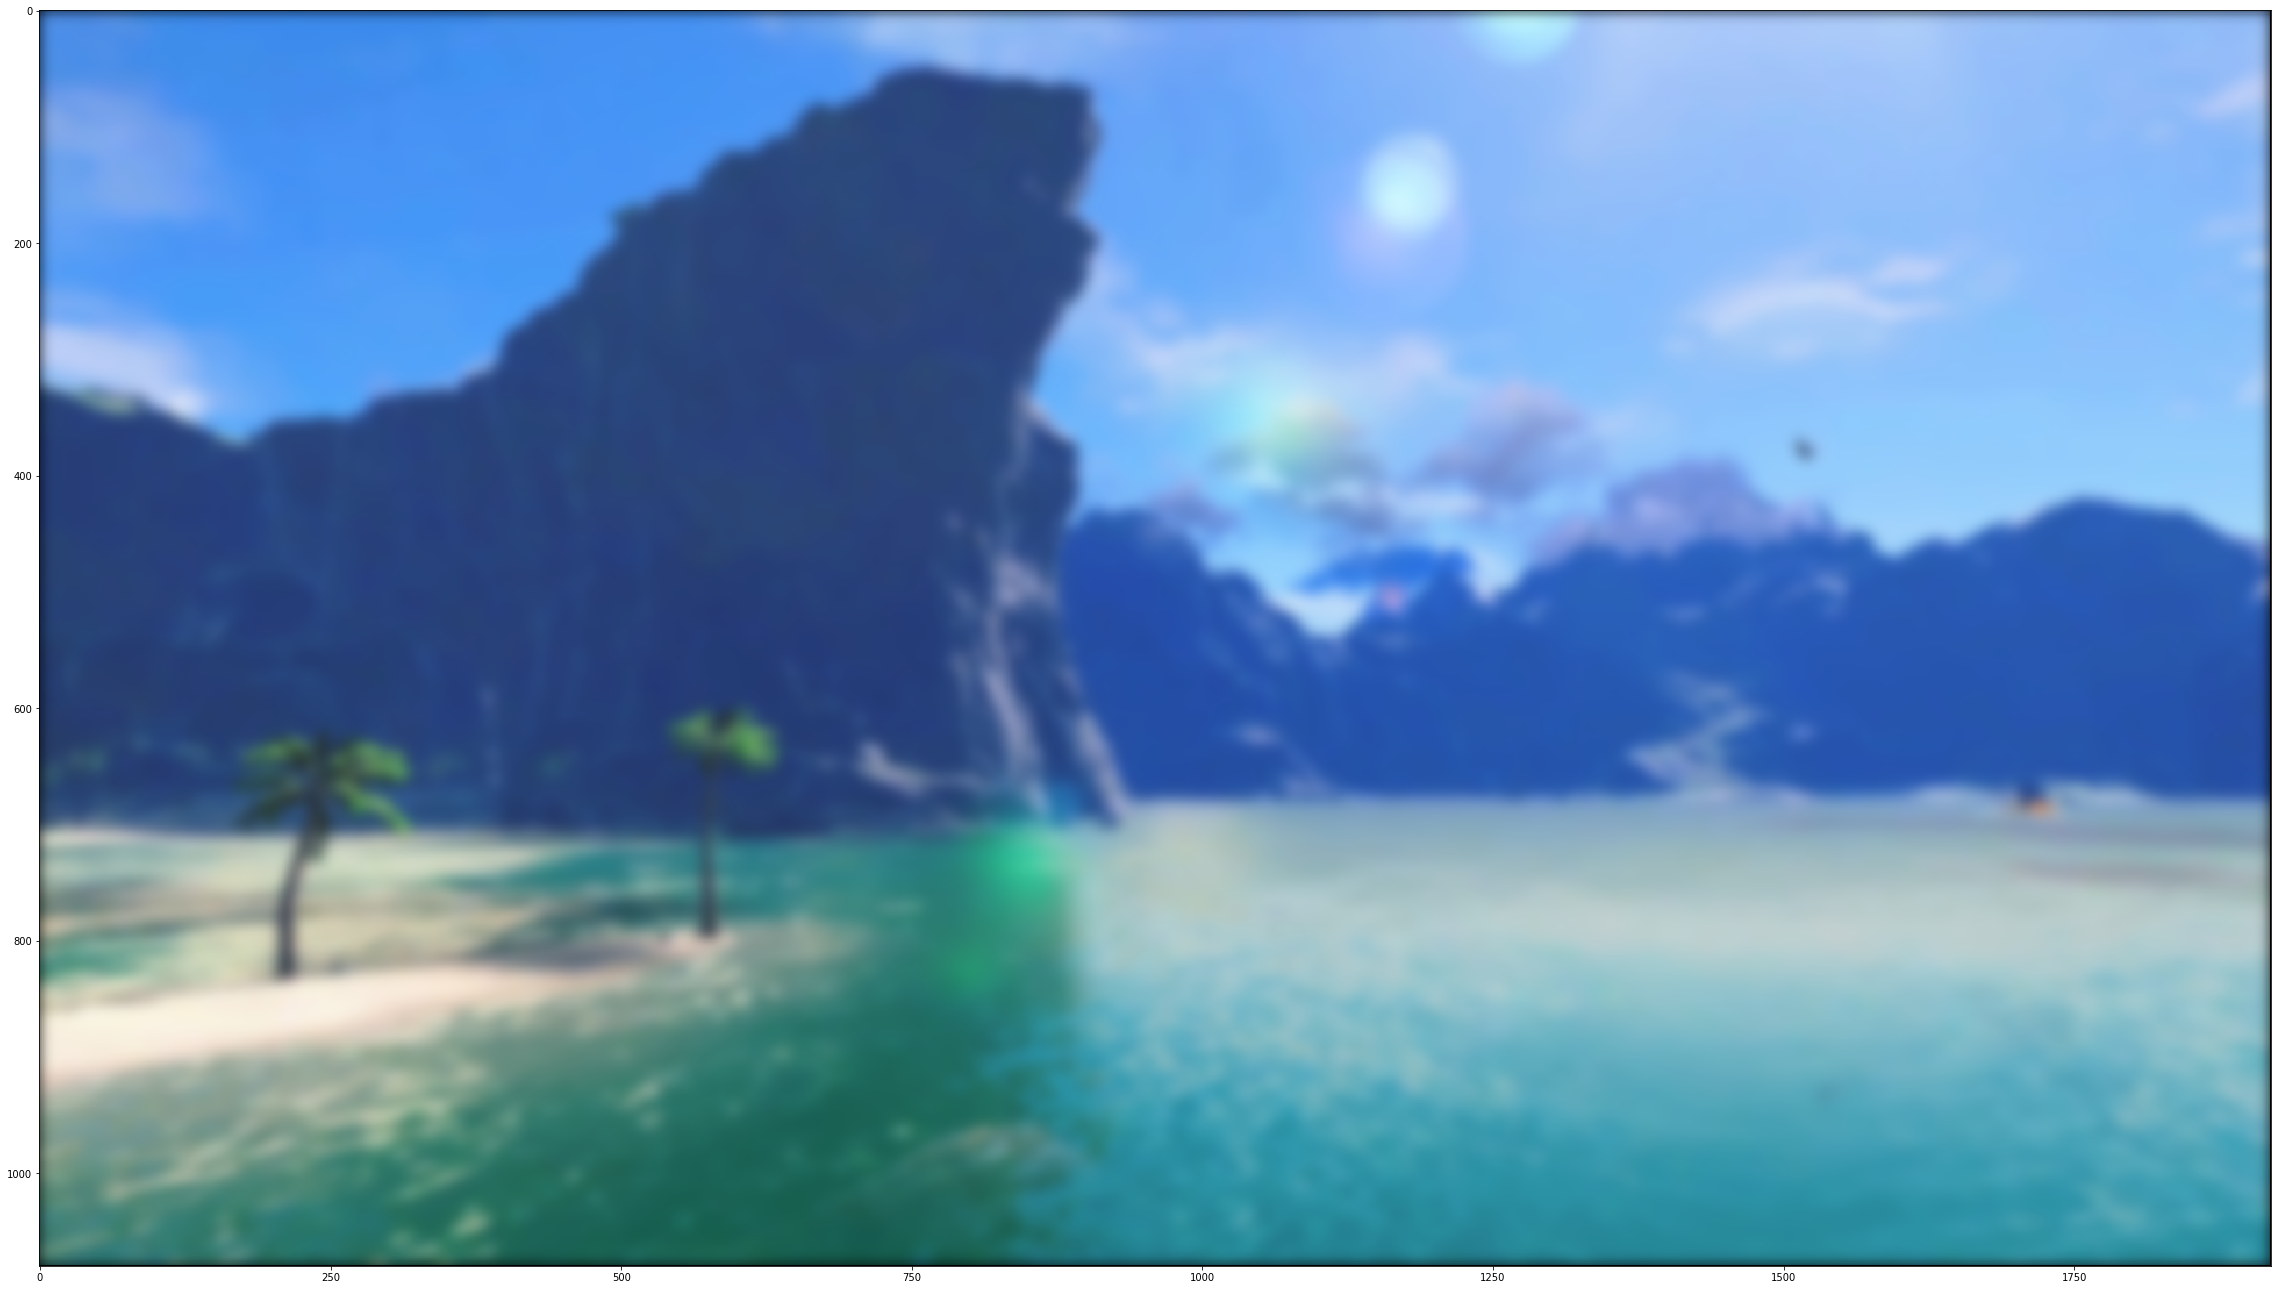

In [56]:
plt.figure(figsize = (40,40))
plt.imshow(np.array(cy_image_convolved,dtype="uint8"))

In [57]:
K_g = gaussian_kernel_2d(20)

In [58]:
cy_image_convolved = cy_convolve(np.array(im, dtype="float64"), K_g)

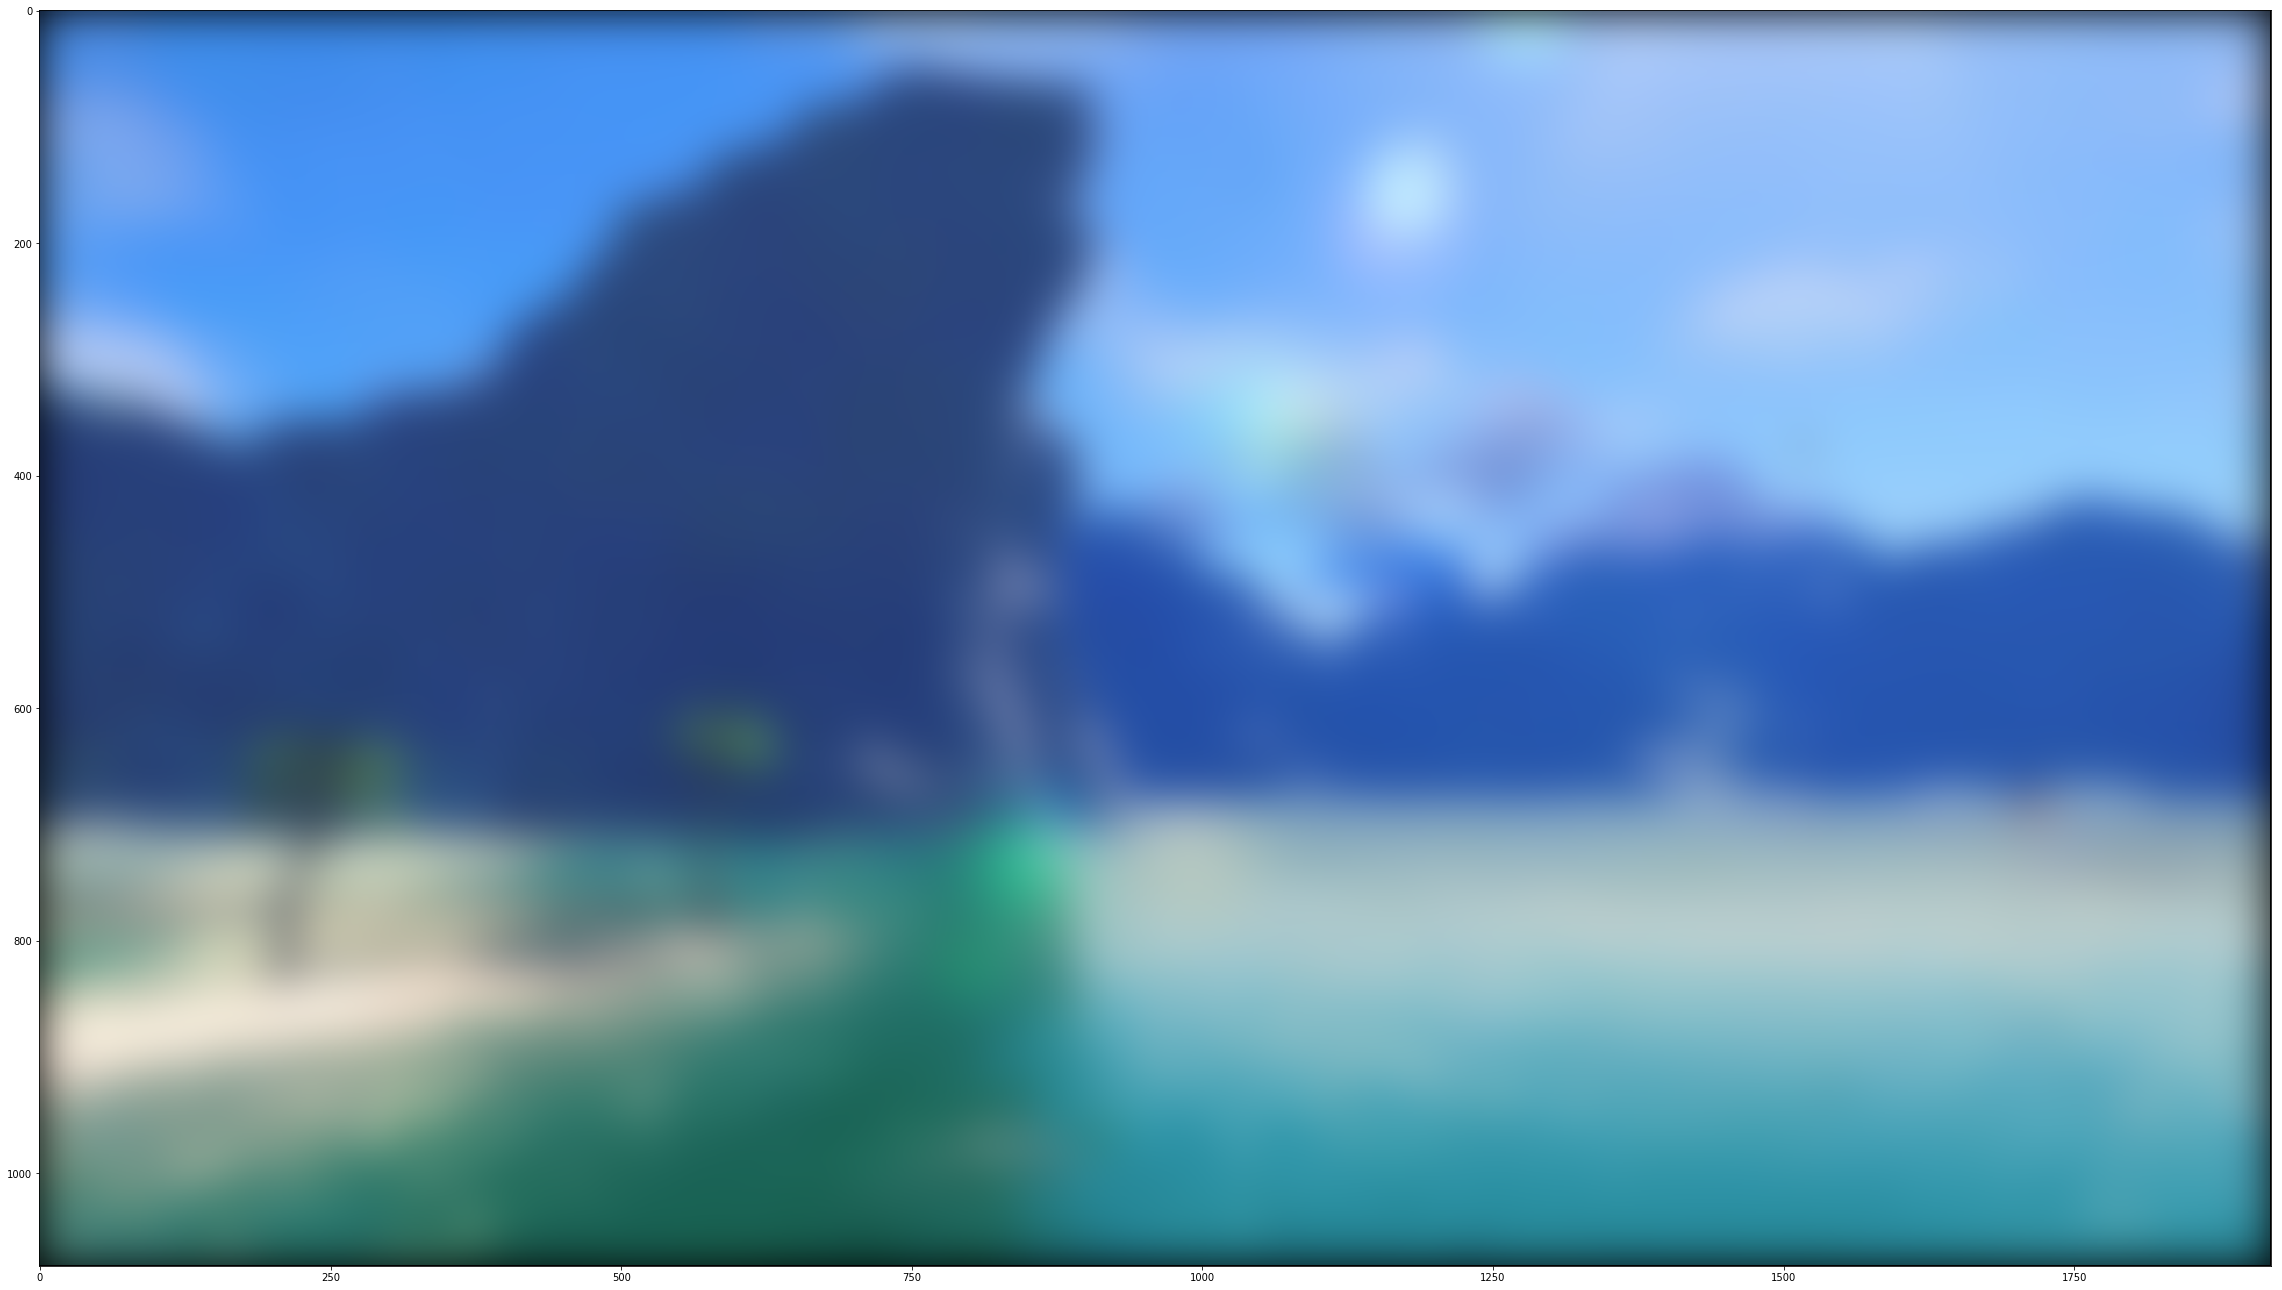

In [59]:
plt.figure(figsize = (40,40))
plt.imshow(np.array(cy_image_convolved,dtype="uint8"))